<a href="https://colab.research.google.com/github/ambideXtrous9/Predict-Product-Length-from-Amazon-Product-Description-NLP-Regression-using-LM/blob/main/Product_Length_from_Description_NLP_Regression_Pytorch_Lightning_FlanT5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Dec 17 14:51:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning
!pip install --quiet peft
!pip install --quiet sentencepiece
!pip install --quiet datasets
!pip install --quiet accelerate
!pip install --quiet bitsandbytes
!pip install --quiet openpyxl
!pip install --quiet evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00


In [ ]:
!pip install --quiet wget

  Preparing metadata (setup.py) ... done


In [ ]:
import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from scipy.stats import norm, skew #for some statistics
from scipy import stats

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding

In [ ]:
_URL = 'https://s3-ap-southeast-1.amazonaws.com/he-public-data/datasetb2d9982.zip'
wget.download(_URL)

'datasetb2d9982.zip'

In [ ]:
!unzip /content/datasetb2d9982.zip -d /content/

Archive:  /content/datasetb2d9982.zip
   creating: /content/dataset/
  inflating: /content/dataset/sample_submission.csv  
  inflating: /content/dataset/train.csv  
  inflating: /content/dataset/test.csv  


In [ ]:
import re
def clean(text):
    text = re.sub(r"http\S+", " ", text) # remove urls
    text = re.sub(r"RT ", " ", text) # remove rt
    text = re.sub(r"[^a-zA-Z\'\.\,\d\s]", " ", text) # remove special character except # @ . ,
    #text = re.sub(r"[0-9]", " ", text) # remove number
    text = re.sub(r'\t', ' ', text) # remove tabs
    text = re.sub(r'\n', ' ', text) # remove line jump
    text = re.sub(r"\s+", " ", text) # remove extra white space
    text = text.strip()
    return text

In [ ]:
path = '/content/dataset/train.csv'

In [ ]:
df = pd.read_csv(path)
df

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000
...,...,...,...,...,...,...
2249693,2422167,Nike Women's As W Ny Df Swsh Hn Kh Bra (CZ7610...,Material : Polyester,NaN,3009,1181.100000
2249694,2766635,"(3PCS) Goose Game Cute Cartoon Enamel Pins, Fu...",[❤ [Inspiration] Inspired by the Untitled Goos...,<p><b>[Brand]: </b>XVIEONR</p> <p><br></p> <p>...,3413,125.984252
2249695,1987786,Kangroo Sweep Movement Printed Wooden Wall Clo...,"[Dial size: 12 inches in diameter,Big, clear r...",Wall Clocks Are Very Attractive In Looks And E...,1574,1200.000000
2249696,1165754,Electro Voice EKX-BRKT15 | Wall Mount Bracket ...,NaN,NaN,592,2900.000000


In [ ]:
df['summary'] = df['TITLE'].fillna("") + " " + df['BULLET_POINTS'].fillna("") + " " + df['DESCRIPTION'].fillna("")

In [ ]:
df['summary'].isna().sum()

0

In [ ]:
df['summary'] = df['summary'].apply(clean)

In [ ]:
df['summary']

0          ArtzFolio Tulip Flowers Blackout Curtain for D...
1          Marks Spencer Girls' Pyjama Sets T86 2561C Nav...
2          PRIKNIK Horn Red Electric Air Horn Compressor ...
3          ALISHAH Women's Cotton Ankle Length Leggings C...
4          The United Empire Loyalists A Chronicle of the...
                                 ...                        
2249693    Nike Women's As W Ny Df Swsh Hn Kh Bra CZ7610 ...
2249694    3PCS Goose Game Cute Cartoon Enamel Pins, Funn...
2249695    Kangroo Sweep Movement Printed Wooden Wall Clo...
2249696    Electro Voice EKX BRKT15 Wall Mount Bracket fo...
2249697    Skyjacker C7360SP Component Box For PN C7360PK...
Name: summary, Length: 2249698, dtype: object

In [ ]:
import matplotlib.pyplot as plt

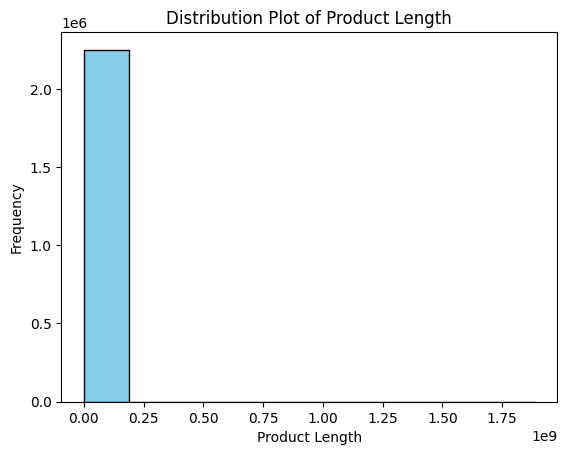

In [ ]:
product_length = df['PRODUCT_LENGTH']

# Create a histogram with more bins
plt.hist(product_length, bins=10, edgecolor='k', color='skyblue')
plt.xlabel('Product Length')
plt.ylabel('Frequency')
plt.title('Distribution Plot of Product Length')
plt.show()

In [ ]:
# Define the threshold value
threshold = 3000

# Create a boolean mask for rows to be removed
mask = df['PRODUCT_LENGTH'] > threshold

# Apply the mask to remove rows
df = df[~mask]

# Optionally, you can reset the index of the filtered DataFrame
df = df.reset_index(drop=True)

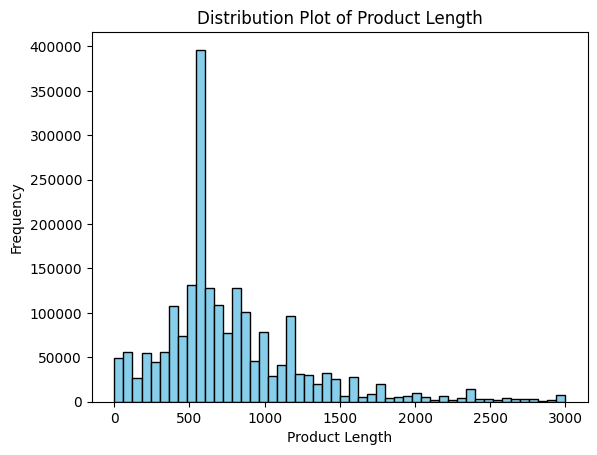

In [ ]:
product_length = df['PRODUCT_LENGTH']

# Create a histogram with more bins
plt.hist(product_length, bins=50, edgecolor='k', color='skyblue')
plt.xlabel('Product Length')
plt.ylabel('Frequency')
plt.title('Distribution Plot of Product Length')
plt.show()

In [ ]:
df['sentence_lengths'] = df['summary'].apply(lambda x: len(x.split()))

# Find the maximum and minimum sentence lengths
max_sentence_length = df['sentence_lengths'].max()
min_sentence_length = df['sentence_lengths'].min()

print("Maximum Sentence Length (in words):", max_sentence_length)
print("Minimum Sentence Length (in words):", min_sentence_length)

Maximum Sentence Length (in words): 1146
Minimum Sentence Length (in words): 0


In [ ]:
# Create a boolean mask for rows with sentence length 0
mask = df['sentence_lengths'] == 0

# Apply the mask to remove rows
df = df[~mask]

# Optionally, you can reset the index of the filtered DataFrame
df = df.reset_index(drop=True)

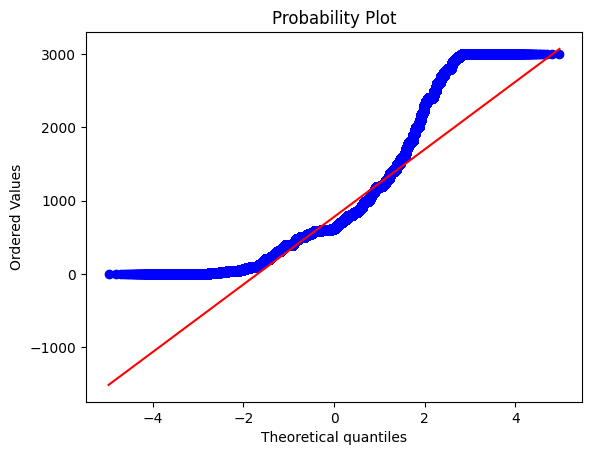

In [ ]:
fig = plt.figure()
res = stats.probplot(df['PRODUCT_LENGTH'], plot=plt)
plt.show()

In [ ]:
# Apply the Box-Cox transformation
transformed_length, lambda_value = stats.boxcox(df['PRODUCT_LENGTH'])

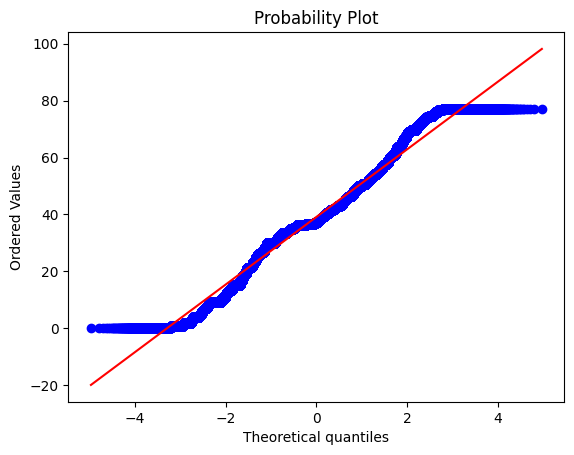

In [ ]:
fig = plt.figure()
res = stats.probplot(transformed_length, plot=plt)
plt.show()

In [ ]:
df['PL'] = transformed_length

In [ ]:
df

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH,summary,sentence_lengths,PL
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000,ArtzFolio Tulip Flowers Blackout Curtain for D...,167,65.842207
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000,Marks Spencer Girls' Pyjama Sets T86 2561C Nav...,28,29.886966
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495,PRIKNIK Horn Red Electric Air Horn Compressor ...,98,40.517649
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574,ALISHAH Women's Cotton Ankle Length Leggings C...,171,41.505607
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000,The United Empire Loyalists A Chronicle of the...,10,36.472828
...,...,...,...,...,...,...,...,...,...
2125721,2422167,Nike Women's As W Ny Df Swsh Hn Kh Bra (CZ7610...,Material : Polyester,NaN,3009,1181.100000,Nike Women's As W Ny Df Swsh Hn Kh Bra CZ7610 ...,19,50.162743
2125722,2766635,"(3PCS) Goose Game Cute Cartoon Enamel Pins, Fu...",[❤ [Inspiration] Inspired by the Untitled Goos...,<p><b>[Brand]: </b>XVIEONR</p> <p><br></p> <p>...,3413,125.984252,"3PCS Goose Game Cute Cartoon Enamel Pins, Funn...",170,17.100608
2125723,1987786,Kangroo Sweep Movement Printed Wooden Wall Clo...,"[Dial size: 12 inches in diameter,Big, clear r...",Wall Clocks Are Very Attractive In Looks And E...,1574,1200.000000,Kangroo Sweep Movement Printed Wooden Wall Clo...,181,50.534533
2125724,1165754,Electro Voice EKX-BRKT15 | Wall Mount Bracket ...,NaN,NaN,592,2900.000000,Electro Voice EKX BRKT15 Wall Mount Bracket fo...,13,75.937155


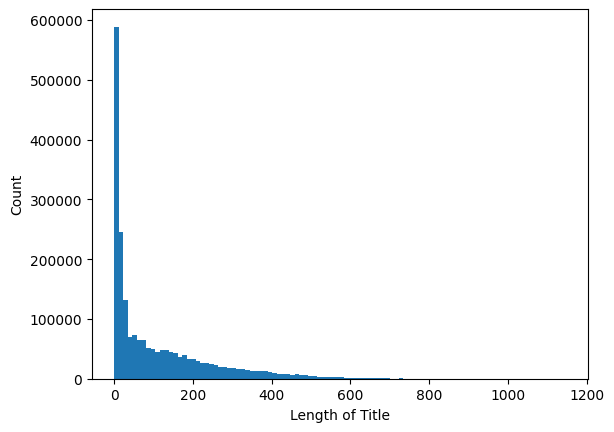

In [ ]:
# Plot histogram of length column
plt.hist(df['sentence_lengths'], bins=100)
# Set x and y labels
plt.xlabel('Length of Title')
plt.ylabel('Count')

# Show the plot
plt.show()

In [ ]:
MODEL_NAME = 'google/flan-t5-small'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Set the number of rows you want to select randomly
num_rows_to_select = 5000

# Use the sample method to select rows randomly
df = df.sample(n=num_rows_to_select, random_state=42)  # Use a random_state for reproducibility

# Reset the index of the sampled DataFrame if needed
df = df.reset_index(drop=True)

In [ ]:
train_df, val_df = train_test_split(df,test_size=0.2)
val_df, test_df = train_test_split(val_df,test_size=0.5)

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((4000, 9), (500, 9), (500, 9))

In [ ]:
class NQADataset(Dataset):
  def __init__(self,data : pd.DataFrame,tokenizer ,source_max_token_len : int = 300,target_max_token_len : int = 32):

    self.tokenizer = tokenizer
    self.data = data
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self,index : int):
    data_row = self.data.iloc[index]

    source_encoding = tokenizer(
        data_row['summary'],
        max_length = self.source_max_token_len,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt")

    return dict(
        actual = torch.tensor(data_row['PRODUCT_LENGTH'], dtype=torch.float32),
        input_ids = source_encoding['input_ids'].flatten(),
        attention_mask = source_encoding['attention_mask'].flatten(),
        labels = torch.tensor(data_row['PL'], dtype=torch.float32))


In [ ]:
class NQADataModule(pl.LightningDataModule):
  def __init__(self,train_df , val_df, test_df,tokenizer ,batch_size : int = 8,source_max_token_len : int = 300,target_max_token_len : int = 32):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.val_df = val_df
    self.tokenizer = tokenizer
    self.source_max_token_len = source_max_token_len
    self.target_max_token_len = target_max_token_len

  def setup(self,stage=None):
    self.train_dataset = NQADataset(self.train_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)
    self.val_dataset = NQADataset(self.val_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)
    self.test_dataset = NQADataset(self.test_df,self.tokenizer,self.source_max_token_len,self.target_max_token_len)


  def train_dataloader(self):
    return DataLoader(self.train_dataset,batch_size = self.batch_size,shuffle=True,num_workers=2)

  def val_dataloader(self):
    return DataLoader(self.val_dataset,batch_size = self.batch_size,num_workers=2)

  def test_dataloader(self):
    return DataLoader(self.test_dataset,batch_size = self.batch_size,num_workers=2)

In [ ]:
from sklearn.metrics import mean_squared_error
from torchmetrics.regression import MeanAbsolutePercentageError

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [50]:
class NQAModel(pl.LightningModule):
  def __init__(self):
    super().__init__()

    self.MAPE = MeanAbsolutePercentageError()

    self.model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,
                                                                    num_labels=1)

  def forward(self,input_ids,attention_mask,labels=None):
    output = self.model(input_ids = input_ids,
                        attention_mask = attention_mask,
                        labels = labels)

    return output

  def training_step(self,batch,batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    pred = self(input_ids,attention_mask,labels)

    # mape = self.MAPE(labels.unsqueeze(1), pred.logits)

    self.log_dict({"train_loss" : pred.loss,
                   #"train_MAPE" : mape
                   },prog_bar=True,logger=True)

    return pred.loss

  def validation_step(self,batch,batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']

    pred = self(input_ids,attention_mask)

    mape = self.MAPE(labels.unsqueeze(1), pred.logits)

    rmse = mean_squared_error(labels.cpu(), pred.logits.cpu(), squared=False)


    self.log_dict({"val_MAPE" : mape,
                   "val_RMSE" : rmse,
                   },prog_bar=True,logger=True)

  def configure_optimizers(self):
    return AdamW(self.parameters(),lr = 0.0001)

In [51]:
BATCH_SIZE = 24
N_EPOCHS = 20

data_module = NQADataModule(train_df,val_df,test_df,tokenizer,batch_size = BATCH_SIZE)
data_module.setup()

In [52]:
model = NQAModel()

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized: ['classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best_cp',
    save_top_k = 1,
    verbose = True,
    monitor = 'val_MAPE',
    mode = 'min'
)

In [54]:
from pytorch_lightning.callbacks import RichProgressBar

In [55]:
rpb = RichProgressBar()

In [56]:
trainer = pl.Trainer(accelerator="gpu",
                     devices=-1,
                     callbacks=[checkpoint_callback,rpb],
                     max_epochs = N_EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [57]:
trainer.fit(model,data_module)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type                        ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ MAPE  │ MeanAbsolutePercentageError │      0 │
│ 1 │ model │ T5ForSequenceClassification │ 60.8 M │
└───┴───────┴─────────────────────────────┴────────┘

Trainable params: 60.8 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 60.8 M                                                                                               
Total estimated model params size (MB): 243

Output()

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 167: 'val_MAPE' reached 0.78602 (best 0.78602), saving model to '/content/checkpoints/best_cp-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 334: 'val_MAPE' reached 0.39164 (best 0.39164), saving model to '/content/checkpoints/best_cp-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 501: 'val_MAPE' reached 0.26411 (best 0.26411), saving model to '/content/checkpoints/best_cp-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 668: 'val_MAPE' reached 0.22015 (best 0.22015), saving model to '/content/checkpoints/best_cp-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 835: 'val_MAPE' reached 0.21442 (best 0.21442), saving model to '/content/checkpoints/best_cp-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1002: 'val_MAPE' reached 0.21284 (best 0.21284), saving 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, 
attempting graceful shutdown...

In [58]:
# with torch.no_grad():
#     torch.cuda.empty_cache()
#     !nvidia-smi

In [59]:
# cppath = '/content/checkpoints/best_cp-v1.ckpt'
# trained_model = NQAModel.load_from_checkpoint(cppath)
# trained_model.freeze()

In [60]:
val_df.iloc[0]['summary']

'DR. BARBARA STURM Eye Cream 15ml'

In [61]:
from scipy.special import inv_boxcox

In [64]:
def predict(idx):
  inputs = tokenizer(
        val_df.iloc[idx]['summary'],
        max_length = 300,
        padding = "max_length",
        truncation = True,
        return_attention_mask = True,
        add_special_tokens = True,
        return_tensors = "pt").to(device)

  model.freeze()
  model.eval()
  with torch.no_grad():
    logits = model(**inputs).logits.item()

  print("ACTUAL : ",val_df.iloc[idx]['PRODUCT_LENGTH'])
  invbxcxact = inv_boxcox(val_df.iloc[idx]['PL'], lambda_value)
  print("\n\nINV BOX-COX ACTUAL : ",invbxcxact)
  pred = inv_boxcox(logits, lambda_value)
  print("\n\nPREDICTED : ",logits)
  print("\n\nINV BOX-COX PREDICTED : ",pred)



In [71]:
predict(10)

ACTUAL :  744.0


INV BOX-COX ACTUAL :  743.9999999999998


PREDICTED :  42.06221389770508


INV BOX-COX PREDICTED :  810.0766325505258
